<a href="https://colab.research.google.com/github/1489685175z-coder/Bird_Speicy_Classification/blob/main/Bird_Speicy_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Project: Fine-Grained Bird Species Classification on CUB-200-2011
# Compare: Pretrained ResNet-18 vs Simple CNN from scratch (baseline)
# Dataset: bentrevett/caltech-ucsd-birds-200-2011 from Hugging Face

# =============================================================================
# 1. Import libraries
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# =============================================================================
# 2. Device & Hyperparameters
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device：{device}")

BATCH_SIZE = 64
NUM_EPOCHS = 20
NUM_CLASSES = 200

models_config = [
    {"name": "resnet18",   "pretrained": True,  "lr": 0.001},
    {"name": "simple_cnn", "pretrained": False, "lr": 0.01}
]

Using device：cuda


In [3]:
# =============================================================================
# 3. Load Dataset from Hugging Face
# =============================================================================
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Loading dataset...")
hf_dataset = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")

class CUBDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image'].convert('RGB')
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

full_train_ds = CUBDataset(hf_dataset['train'], train_transform)
test_ds = CUBDataset(hf_dataset['test'], test_transform)

train_size = int(0.85 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=device.type=='cuda')
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=device.type=='cuda')
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=device.type=='cuda')

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}, Test samples: {len(test_ds)}")

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train samples: 5094, Val samples: 900, Test samples: 5794


In [4]:
# =============================================================================
# 4.Train and Evaluate Function
# =============================================================================
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(loader), correct / total

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    return accuracy_score(all_labels, all_preds)

In [5]:
# =============================================================================
# 5. Main Training Loop
# =============================================================================
all_history = {}
test_results = {}

for config in models_config:
    name = config["name"]
    print(f"\n===== Training {name} =====")

    if name == "resnet18":
        model = models.resnet18(pretrained=config["pretrained"])
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, NUM_CLASSES)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True

    elif name == "simple_cnn":
        class SimpleCNN(nn.Module):
            def __init__(self, num_classes=200):
                super().__init__()
                self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
                self.pool = nn.MaxPool2d(2, 2)
                self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
                self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
                self.flatten = nn.Flatten()
                self.fc1 = nn.Linear(128 * 28 * 28, 512)
                self.dropout = nn.Dropout(0.5)
                self.fc2 = nn.Linear(512, num_classes)

            def forward(self, x):
                x = torch.relu(self.conv1(x)); x = self.pool(x)
                x = torch.relu(self.conv2(x)); x = self.pool(x)
                x = torch.relu(self.conv3(x)); x = self.pool(x)
                x = self.flatten(x)
                x = torch.relu(self.fc1(x))
                x = self.dropout(x)
                x = self.fc2(x)
                return x

        model = SimpleCNN(NUM_CLASSES)
        for param in model.parameters():
            param.requires_grad = True

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()) if name == "resnet18" else model.parameters(),
        lr=config["lr"]
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    history = {"train_loss": [], "train_acc": [], "val_acc": []}
    best_val = 0.0

    for epoch in range(NUM_EPOCHS):
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        va_acc = evaluate(model, val_loader, device)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        print(f"[{name}] Epoch {epoch+1:2d}/{NUM_EPOCHS} | Loss: {tr_loss:.4f} | Tr Acc: {tr_acc:.4f} | Val Acc: {va_acc:.4f}")

        scheduler.step(va_acc)

        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), f"best_{name}.pth")

    model.load_state_dict(torch.load(f"best_{name}.pth", map_location=device))
    test_acc = evaluate(model, test_loader, device)
    test_results[name] = test_acc
    all_history[name] = history
    print(f"[{name}] Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)\n")


===== Training resnet18 =====


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
评估中: 100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


[resnet18] Epoch  1/20 | Loss: 4.1636 | Tr Acc: 0.1368 | Val Acc: 0.2222


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


[resnet18] Epoch  2/20 | Loss: 2.7141 | Tr Acc: 0.3437 | Val Acc: 0.2967


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


[resnet18] Epoch  3/20 | Loss: 2.1919 | Tr Acc: 0.4511 | Val Acc: 0.3444


评估中: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


[resnet18] Epoch  4/20 | Loss: 1.8838 | Tr Acc: 0.5277 | Val Acc: 0.4200


评估中: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


[resnet18] Epoch  5/20 | Loss: 1.6720 | Tr Acc: 0.5720 | Val Acc: 0.4767


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[resnet18] Epoch  6/20 | Loss: 1.5240 | Tr Acc: 0.6148 | Val Acc: 0.4500


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


[resnet18] Epoch  7/20 | Loss: 1.3586 | Tr Acc: 0.6492 | Val Acc: 0.4744


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


[resnet18] Epoch  8/20 | Loss: 1.2821 | Tr Acc: 0.6649 | Val Acc: 0.4833


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


[resnet18] Epoch  9/20 | Loss: 1.2036 | Tr Acc: 0.6922 | Val Acc: 0.4822


评估中: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


[resnet18] Epoch 10/20 | Loss: 1.1305 | Tr Acc: 0.7077 | Val Acc: 0.4889


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[resnet18] Epoch 11/20 | Loss: 1.0733 | Tr Acc: 0.7148 | Val Acc: 0.4700


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


[resnet18] Epoch 12/20 | Loss: 1.0487 | Tr Acc: 0.7318 | Val Acc: 0.4778


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


[resnet18] Epoch 13/20 | Loss: 1.0022 | Tr Acc: 0.7346 | Val Acc: 0.4922


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


[resnet18] Epoch 14/20 | Loss: 0.9448 | Tr Acc: 0.7583 | Val Acc: 0.4944


评估中: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


[resnet18] Epoch 15/20 | Loss: 0.9504 | Tr Acc: 0.7519 | Val Acc: 0.4689


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[resnet18] Epoch 16/20 | Loss: 0.9039 | Tr Acc: 0.7686 | Val Acc: 0.4800


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


[resnet18] Epoch 17/20 | Loss: 0.8389 | Tr Acc: 0.7837 | Val Acc: 0.4511


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


[resnet18] Epoch 18/20 | Loss: 0.8000 | Tr Acc: 0.7943 | Val Acc: 0.5211


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


[resnet18] Epoch 19/20 | Loss: 0.8034 | Tr Acc: 0.7901 | Val Acc: 0.4967


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[resnet18] Epoch 20/20 | Loss: 0.7868 | Tr Acc: 0.7974 | Val Acc: 0.5267


评估中: 100%|██████████| 91/91 [00:29<00:00,  3.08it/s]


[resnet18] Test Accuracy: 0.6237 (62.37%)


===== Training simple_cnn =====


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


[simple_cnn] Epoch  1/20 | Loss: 12.2204 | Tr Acc: 0.0024 | Val Acc: 0.0022


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


[simple_cnn] Epoch  2/20 | Loss: 5.3039 | Tr Acc: 0.0035 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


[simple_cnn] Epoch  3/20 | Loss: 5.3026 | Tr Acc: 0.0037 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


[simple_cnn] Epoch  4/20 | Loss: 5.3032 | Tr Acc: 0.0027 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


[simple_cnn] Epoch  5/20 | Loss: 5.3026 | Tr Acc: 0.0033 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


[simple_cnn] Epoch  6/20 | Loss: 5.2995 | Tr Acc: 0.0057 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


[simple_cnn] Epoch  7/20 | Loss: 5.2997 | Tr Acc: 0.0057 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


[simple_cnn] Epoch  8/20 | Loss: 5.2994 | Tr Acc: 0.0055 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[simple_cnn] Epoch  9/20 | Loss: 5.2991 | Tr Acc: 0.0055 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


[simple_cnn] Epoch 10/20 | Loss: 5.2977 | Tr Acc: 0.0047 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


[simple_cnn] Epoch 11/20 | Loss: 5.2977 | Tr Acc: 0.0045 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[simple_cnn] Epoch 12/20 | Loss: 5.2976 | Tr Acc: 0.0041 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


[simple_cnn] Epoch 13/20 | Loss: 5.2975 | Tr Acc: 0.0045 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


[simple_cnn] Epoch 14/20 | Loss: 5.2968 | Tr Acc: 0.0047 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


[simple_cnn] Epoch 15/20 | Loss: 5.2968 | Tr Acc: 0.0049 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


[simple_cnn] Epoch 16/20 | Loss: 5.2967 | Tr Acc: 0.0057 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


[simple_cnn] Epoch 17/20 | Loss: 5.2967 | Tr Acc: 0.0051 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


[simple_cnn] Epoch 18/20 | Loss: 5.2963 | Tr Acc: 0.0057 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


[simple_cnn] Epoch 19/20 | Loss: 5.2964 | Tr Acc: 0.0057 | Val Acc: 0.0011


评估中: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


[simple_cnn] Epoch 20/20 | Loss: 5.2963 | Tr Acc: 0.0057 | Val Acc: 0.0011


评估中: 100%|██████████| 91/91 [00:28<00:00,  3.21it/s]

[simple_cnn] Test Accuracy: 0.0052 (0.52%)



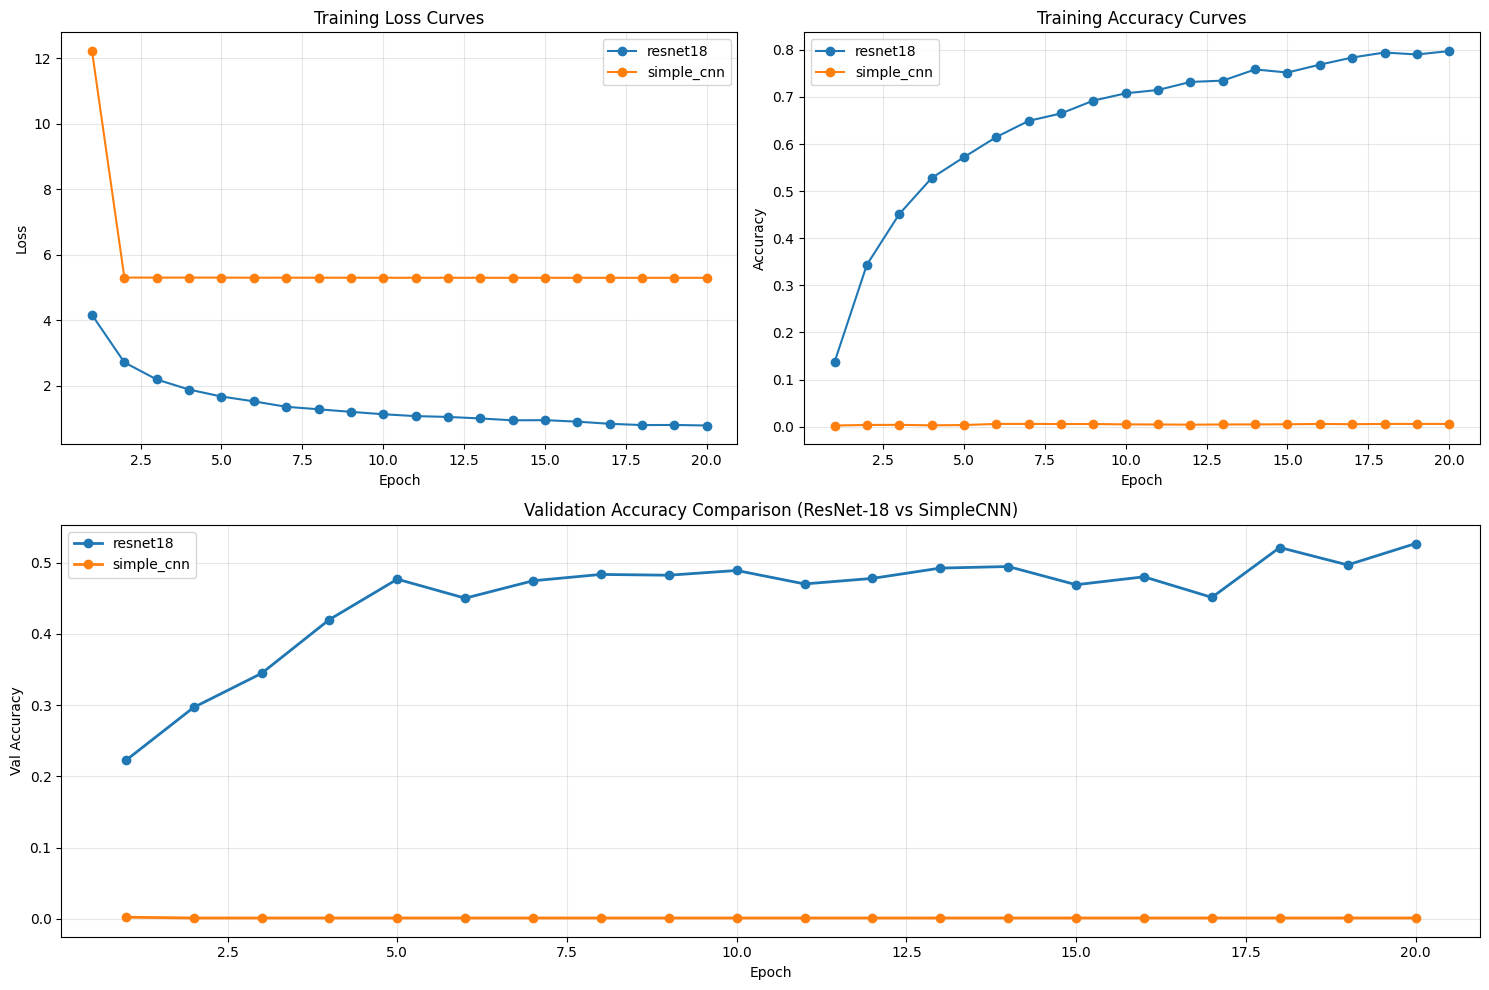


===== Final Comparison Results =====
resnet18     Test Acc: 0.6237 (62.37%)
simple_cnn   Test Acc: 0.0052 ( 0.52%)


In [6]:
# =============================================================================
# 6. Plot training curves comparison
# =============================================================================
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for name, h in all_history.items():
    plt.plot(epochs_range, h["train_loss"], label=name, marker='o')
plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
for name, h in all_history.items():
    plt.plot(epochs_range, h["train_acc"], label=name, marker='o')
plt.title("Training Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
for name, h in all_history.items():
    plt.plot(epochs_range, h["val_acc"], label=name, marker='o', linewidth=2)
plt.title("Validation Accuracy Comparison (ResNet-18 vs SimpleCNN)")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n===== Final Comparison Results =====")
for name, acc in test_results.items():
    print(f"{name:12} Test Acc: {acc:.4f} ({acc*100:5.2f}%)")

Loaded 200 bird species names (example: 001.Black_footed_Albatross, 002.Laysan_Albatross)

===== Error Analysis & Visualization for resnet18 =====


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[resnet18] Collecting predictions: 100%|██████████| 91/91 [00:29<00:00,  3.03it/s]


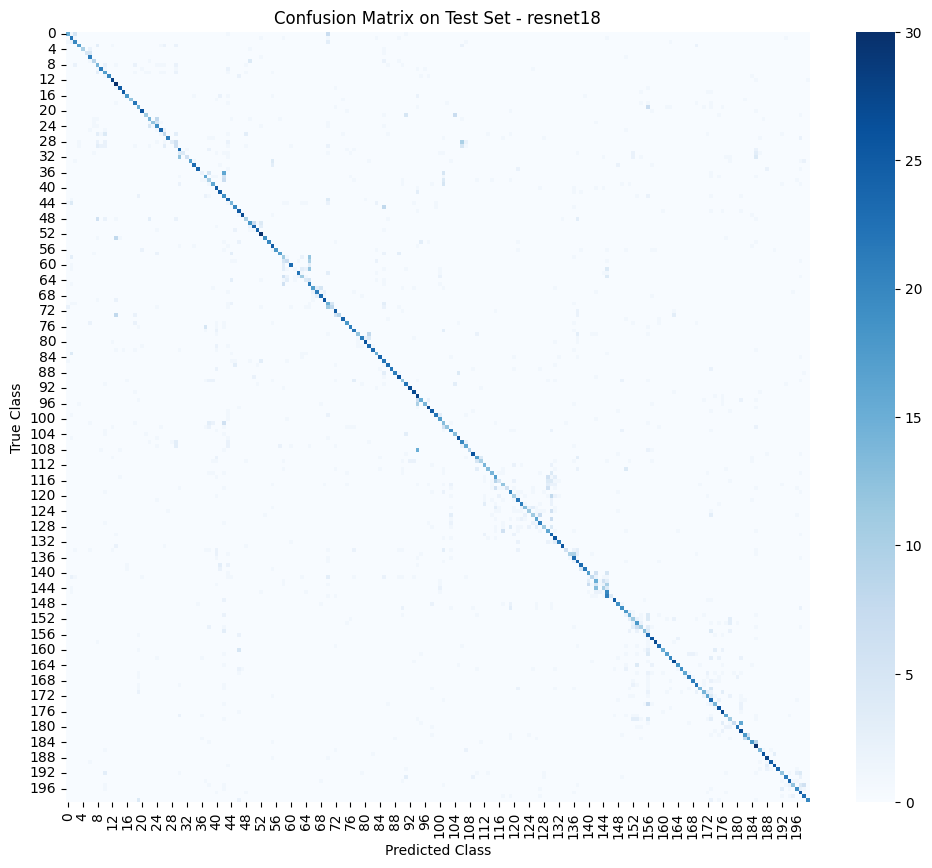

Top 5 most confused bird pairs (True → Predicted):
  147.Least_Tern → 146.Forsters_Tern : 21 times
  037.Acadian_Flycatcher → 043.Yellow_bellied_Flycatcher : 16 times
  180.Wilson_Warbler → 182.Yellow_Warbler : 16 times
  109.American_Redstart → 095.Baltimore_Oriole : 15 times
  145.Elegant_Tern → 143.Caspian_Tern : 13 times
[resnet18] Number of misclassified samples: 2180


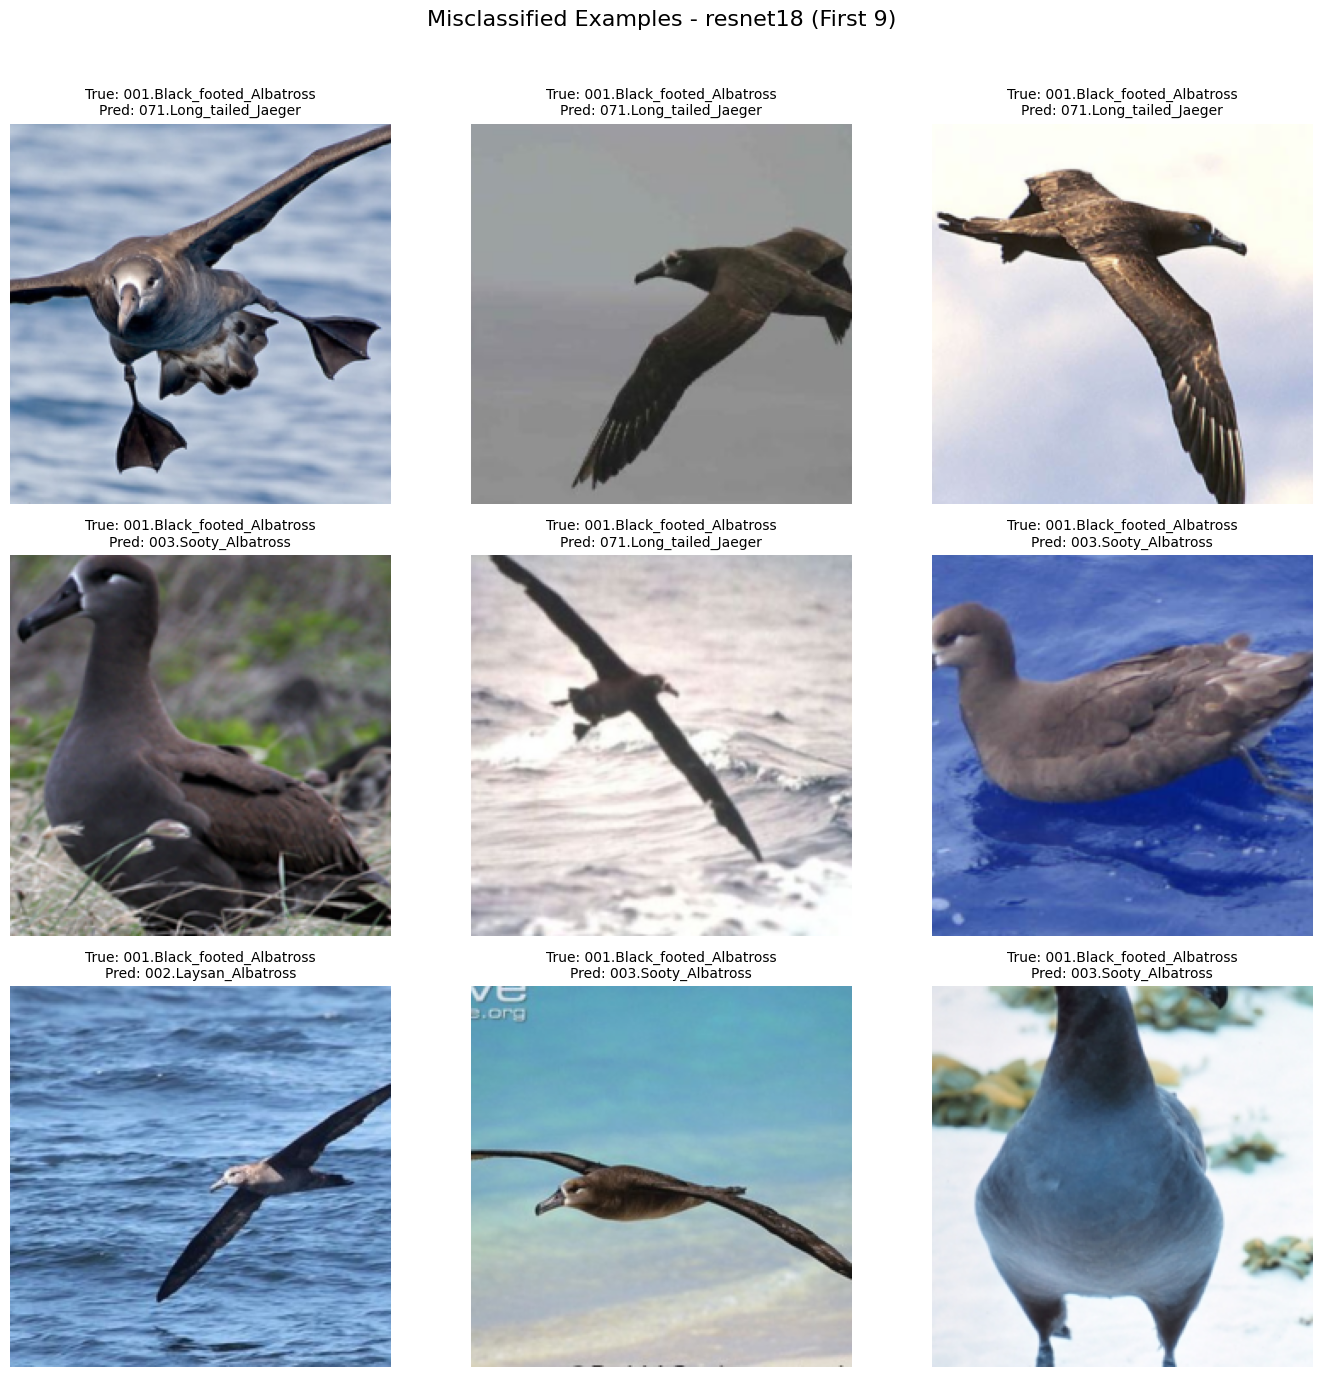

[resnet18] Test Accuracy (re-computed): 0.6237 (62.37%)


===== Error Analysis & Visualization for simple_cnn =====


[simple_cnn] Collecting predictions: 100%|██████████| 91/91 [00:28<00:00,  3.14it/s]


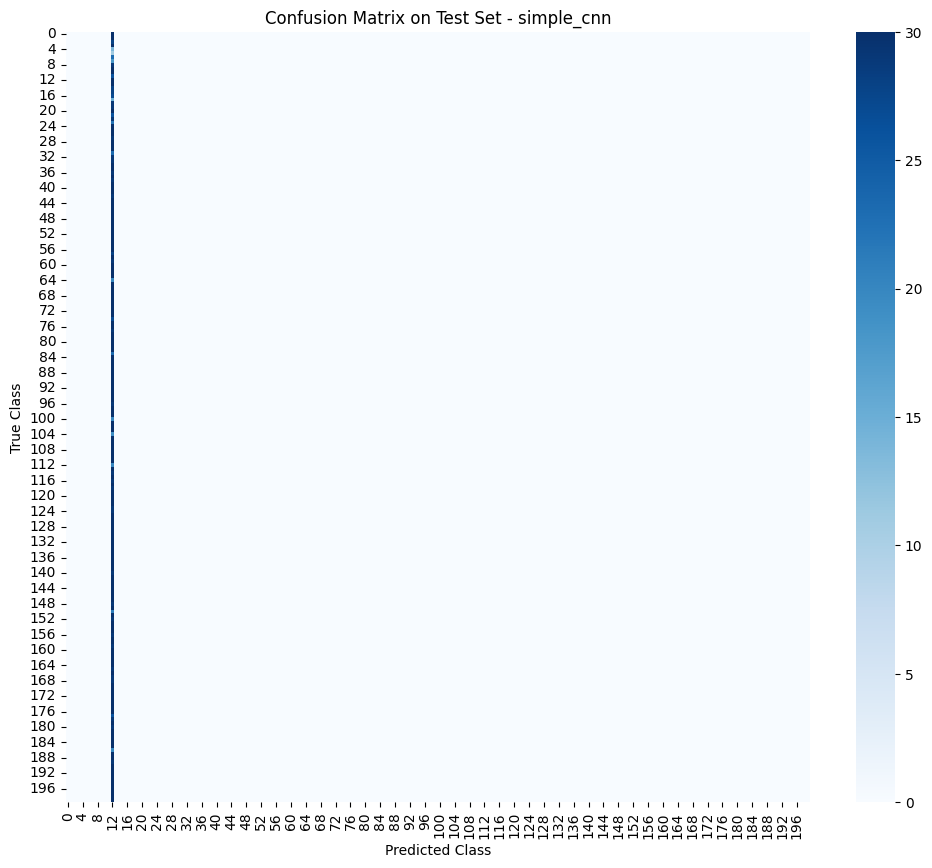

Top 5 most confused bird pairs (True → Predicted):
  001.Black_footed_Albatross → 013.Bobolink : 30 times
  002.Laysan_Albatross → 013.Bobolink : 30 times
  004.Groove_billed_Ani → 013.Bobolink : 30 times
  010.Red_winged_Blackbird → 013.Bobolink : 30 times
  011.Rusty_Blackbird → 013.Bobolink : 30 times
[simple_cnn] Number of misclassified samples: 5764


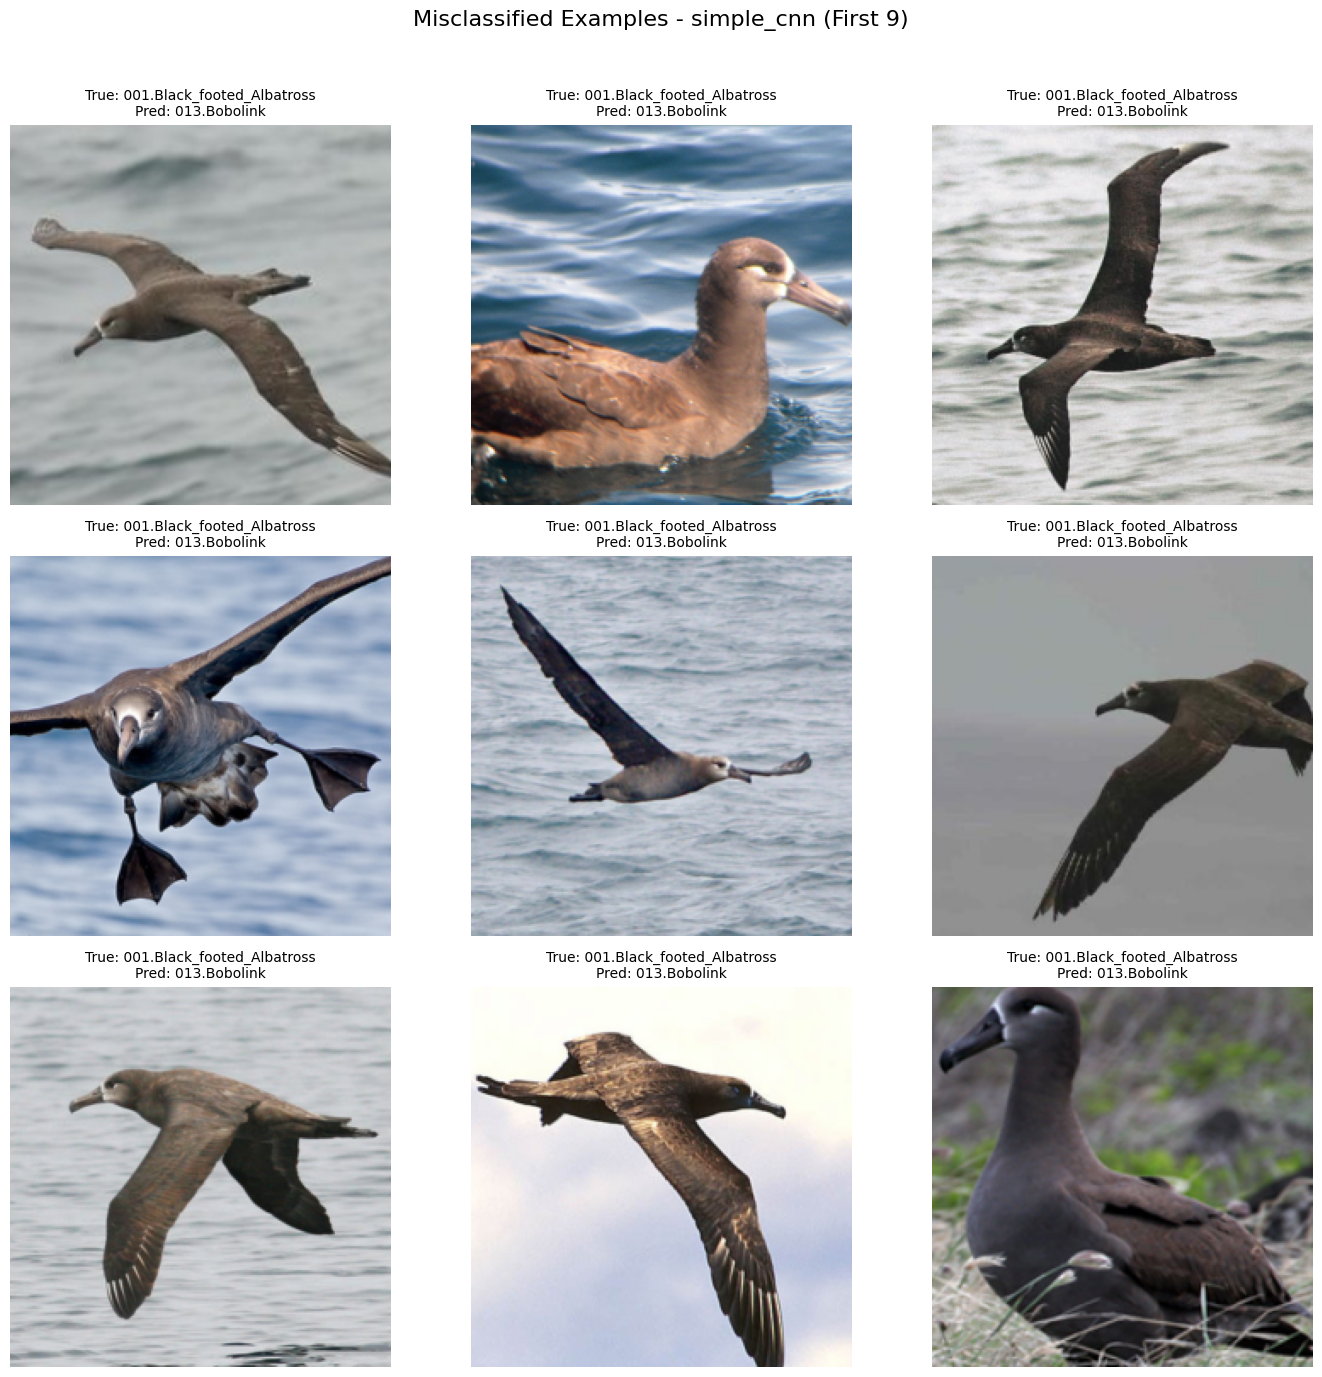

[simple_cnn] Test Accuracy (re-computed): 0.0052 (0.52%)



In [7]:
# =============================================
# 7.Error Analysis & Confusion Matrix
# =============================================

from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Load bird class names
class_names = hf_dataset['train'].features['label'].names
print(f"Loaded {len(class_names)} bird species names (example: {class_names[0]}, {class_names[1]})")

for config in models_config:
    name = config["name"]
    print(f"\n===== Error Analysis & Visualization for {name} =====")

    # Rebuild model structure
    if name == "resnet18":
        model = models.resnet18(pretrained=False)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, NUM_CLASSES)
    elif name == "simple_cnn":
        class SimpleCNN(nn.Module):
            def __init__(self, num_classes=200):
                super().__init__()
                self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
                self.pool = nn.MaxPool2d(2, 2)
                self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
                self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
                self.flatten = nn.Flatten()
                self.fc1 = nn.Linear(128 * 28 * 28, 512)
                self.dropout = nn.Dropout(0.5)
                self.fc2 = nn.Linear(512, num_classes)

            def forward(self, x):
                x = torch.relu(self.conv1(x)); x = self.pool(x)
                x = torch.relu(self.conv2(x)); x = self.pool(x)
                x = torch.relu(self.conv3(x)); x = self.pool(x)
                x = self.flatten(x)
                x = torch.relu(self.fc1(x))
                x = self.dropout(x)
                x = self.fc2(x)
                return x

        model = SimpleCNN(NUM_CLASSES)

    # Load best weights
    model.load_state_dict(torch.load(f"best_{name}.pth", map_location=device))
    model = model.to(device)
    model.eval()

    # Collect predictions and labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"[{name}] Collecting predictions"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # 1. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
    plt.title(f'Confusion Matrix on Test Set - {name}')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.savefig(f'confusion_matrix_{name}.png', dpi=150)
    plt.show()

    # 2. Top 5 most confused pairs
    errors = [(true, pred) for true, pred in zip(all_labels, all_preds) if true != pred]

    if errors:
        most_common_errors = Counter(errors).most_common(5)
        print("Top 5 most confused bird pairs (True → Predicted):")
        for (true_label, pred_label), count in most_common_errors:
            true_name = class_names[true_label]
            pred_name = class_names[pred_label]
            print(f"  {true_name} → {pred_name} : {count} times")
    else:
        print("No errors found! (Perfect prediction - unlikely)")

    # 3. Visualize first 9 misclassified samples
    wrong_idx = np.where(np.array(all_preds) != np.array(all_labels))[0]
    print(f"[{name}] Number of misclassified samples: {len(wrong_idx)}")

    show_n = min(9, len(wrong_idx))
    if show_n > 0:
        fig, axes = plt.subplots(3, 3, figsize=(14, 14))
        axes = axes.flatten()

        # Collect denormalized images for wrong indices
        mis_images = []
        sample_idx = 0
        collected = 0

        with torch.no_grad():
            for batch_images, _ in test_loader:
                for img_tensor in batch_images:
                    if sample_idx in wrong_idx[:show_n]:
                        # Denormalize
                        img = img_tensor.cpu().numpy()  # [3, H, W]
                        img = np.transpose(img, (1, 2, 0))  # [H, W, 3]
                        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                        img = np.clip(img, 0, 1)
                        mis_images.append(img)
                        collected += 1
                    sample_idx += 1
                    if collected >= show_n:
                        break
                if collected >= show_n:
                    break

        # Display
        for i in range(show_n):
            axes[i].imshow(mis_images[i])
            true_name = class_names[all_labels[wrong_idx[i]]]
            pred_name = class_names[all_preds[wrong_idx[i]]]
            axes[i].set_title(f"True: {true_name}\nPred: {pred_name}", fontsize=10)
            axes[i].axis('off')

        for j in range(show_n, 9):
            axes[j].axis('off')

        plt.suptitle(f"Misclassified Examples - {name} (First {show_n})", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print(f"[{name}] No misclassified samples to display.")

    # Re-compute accuracy for confirmation
    test_acc = accuracy_score(all_labels, all_preds)
    print(f"[{name}] Test Accuracy (re-computed): {test_acc:.4f} ({test_acc*100:.2f}%)\n")